In [1]:
import folium
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from shapely.geometry import Polygon
from sklearn.cluster import DBSCAN
from scipy.spatial import ConvexHull

from collections import defaultdict
from math import pi, cos
from dataclasses import dataclass
from loguru import logger

from plot import ecdf
from geogiant.common.files_utils import load_json, load_pickle, load_csv
from geogiant.common.ip_addresses_utils import get_prefix_from_ip
from geogiant.common.settings import PathSettings, ClickhouseSettings

path_settings = PathSettings()
clickhouse_settings = ClickhouseSettings()


@dataclass(frozen=True)
class ResultsScore:
    client_granularity: str
    answer_granularity: str
    scores: list
    inconsistent_mappings: list


targets = load_json(path_settings.OLD_TARGETS)
targets_coordinates = {}
for target in targets:
    if "country_code" in target:
        targets_coordinates[target["address_v4"]] = {
            "lat": target["geometry"]["coordinates"][1],
            "lon": target["geometry"]["coordinates"][0],
            "country_code": target["country_code"],
        }
    else:
        logger.info(f"Missing country code for target: {target['address_v4']}")

vps = load_json(path_settings.OLD_VPS)
vps_coordinates = {}
vps_per_subnet = defaultdict(list)
for vp in vps:
    vps_coordinates[vp["address_v4"]] = {
        "lat": vp["geometry"]["coordinates"][1],
        "lon": vp["geometry"]["coordinates"][0],
        "country_code": vp["country_code"],
    }

    subnet = get_prefix_from_ip(vp["address_v4"])
    vps_per_subnet[subnet].append(vp["address_v4"])


def plotDot(lat, lon, map, color="blue"):
    """input: series that contains a numeric named latitude and a numeric named longitude
    this function creates a CircleMarker and adds it to your this_map"""
    folium.CircleMarker(location=[lat, lon], radius=2, weight=5, color=color).add_to(
        map
    )


def find_exterior_points(points):
    # Create a numpy array from the list of points
    points_array = np.array(points)

    # Compute the convex hull
    hull = ConvexHull(points_array)

    # Extract the indices of exterior points
    exterior_indices = hull.vertices

    # Get the exterior points
    exterior_points = points_array[exterior_indices]

    return exterior_points, hull


def get_median_dist_error(target_results: dict, key: str) -> float:
    """return the median distance error"""
    return round(
        np.median([r[key]["d_error"] for r in target_results.values()]),
        2,
    )

In [2]:
eval_results = load_pickle(
    path_settings.RESULTS_PATH
    / "evaluation_1M_hostnames_answer_bgp_prefix_max_bgp_prefix.pickle"
)

# eval_results = load_pickle(
#     path_settings.RESULTS_PATH
#     / "evaluation_1M_hostnames_answer_bgp_prefix_greedy_cdn.pickle"
# )

In [3]:
answer_granularity = "answer_bgp_prefix"
results = eval_results[answer_granularity]

ref_shortest_ping_m_d = get_median_dist_error(results[50], "ref_shortest_ping_vp")
no_ping_m_d = get_median_dist_error(results[50], "no_ping_vp")
ecs_cluster_shortest_ping_m_d = get_median_dist_error(
    results[50], "ecs_cluster_shortest_ping_vp"
)
# no_ping_cluster_m_d = get_median_dist_error(results[50], "no_ping_cluster_vp")

logger.info(
    f"Reference shortest ping:: median_error={round(ref_shortest_ping_m_d, 2)} [km]"
)
logger.info(f"No ping:: median_error={round(no_ping_m_d, 2)} [km]")
logger.info(
    f"ECS  cluster shortest ping:: median_error={round(ecs_cluster_shortest_ping_m_d, 2)} [km]"
)
# logger.info(f"No ping cluster:: median_error={round(no_ping_cluster_m_d, 2)} [km]")

for budget, target_results in results.items():
    if budget in [10, 20, 30, 50]:
        logger.info(f"Probing budget:: {budget}")
        logger.info(f"Total number of target:: {len(target_results)}")

        ecs_shortest_ping_m_d = get_median_dist_error(
            target_results, "ecs_shortest_ping_vp"
        )

        logger.info(
            f"ECS shortest ping:: median_error={round(ecs_shortest_ping_m_d, 2)} [km]"
        )

2024-03-18 12:25:48.792 | INFO     | __main__:<module>:11 - Reference shortest ping:: median_error=7.03 [km]
2024-03-18 12:25:48.793 | INFO     | __main__:<module>:14 - No ping:: median_error=49.45 [km]
2024-03-18 12:25:48.794 | INFO     | __main__:<module>:15 - ECS  cluster shortest ping:: median_error=15.62 [km]
2024-03-18 12:25:48.795 | INFO     | __main__:<module>:22 - Probing budget:: 10
2024-03-18 12:25:48.796 | INFO     | __main__:<module>:23 - Total number of target:: 721


2024-03-18 12:25:48.801 | INFO     | __main__:<module>:29 - ECS shortest ping:: median_error=13.46 [km]
2024-03-18 12:25:48.802 | INFO     | __main__:<module>:22 - Probing budget:: 20
2024-03-18 12:25:48.802 | INFO     | __main__:<module>:23 - Total number of target:: 726
2024-03-18 12:25:48.805 | INFO     | __main__:<module>:29 - ECS shortest ping:: median_error=9.14 [km]
2024-03-18 12:25:48.806 | INFO     | __main__:<module>:22 - Probing budget:: 30
2024-03-18 12:25:48.807 | INFO     | __main__:<module>:23 - Total number of target:: 726
2024-03-18 12:25:48.810 | INFO     | __main__:<module>:29 - ECS shortest ping:: median_error=8.78 [km]
2024-03-18 12:25:48.810 | INFO     | __main__:<module>:22 - Probing budget:: 50
2024-03-18 12:25:48.811 | INFO     | __main__:<module>:23 - Total number of target:: 726
2024-03-18 12:25:48.813 | INFO     | __main__:<module>:29 - ECS shortest ping:: median_error=8.06 [km]


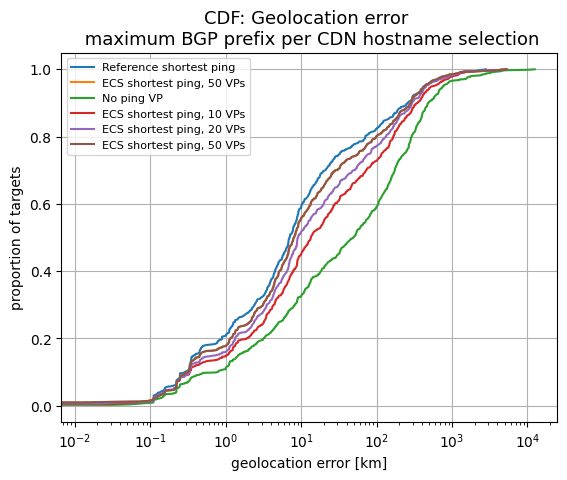

In [9]:
results = eval_results[answer_granularity]

fig, ax1 = plt.subplots(1, 1)

x, y = ecdf([r["ref_shortest_ping_vp"]["d_error"] for r in results[50].values()])
ax1.plot(x, y, label=f"Reference shortest ping")

x, y = ecdf([r["ecs_shortest_ping_vp"]["d_error"] for r in results[50].values()])
ax1.plot(x, y, label=f"ECS shortest ping, 50 VPs")

x, y = ecdf([r["no_ping_vp"]["d_error"] for r in results[50].values()])
ax1.plot(x, y, label=f"No ping VP")

# x, y = ecdf([r["no_ping_cluster_vp"]["d_error"] for r in results[50].values()])
# ax1.plot(x, y, label=f"No ping cluster VP")

for budget, target_results in results.items():

    if budget in [10, 20, 50]:

        x, y = ecdf(
            [r["ecs_shortest_ping_vp"]["d_error"] for r in target_results.values()]
        )
        ax1.plot(x, y, label=f"ECS shortest ping, {budget} VPs")

        # x, y = ecdf(
        #     [
        #         r["ecs_cluster_shortest_ping_vp"]["d_error"]
        #         for r in target_results.values()
        #     ]
        # )
        # ax1.plot(x, y, label=f"ECS Cluster shortest ping, {budget} VPs")

plt.xlabel("geolocation error [km]")
plt.ylabel("proportion of targets")
plt.legend(loc="upper left", fontsize=8)
plt.xscale("log")
plt.grid()
plt.title(
    f"CDF: Geolocation error \n maximum BGP prefix per CDN hostname selection",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "geoloc_error_max_bgp_prefix.pdf")
plt.show()

# Costs

2024-03-18 12:25:49.921 | INFO     | __main__:<module>:36 - Measurement cost = 10
2024-03-18 12:25:49.923 | INFO     | __main__:<module>:37 - Avg Measurement cost ECS selection = 8.75
2024-03-18 12:25:49.925 | INFO     | __main__:<module>:38 - Median Measurement cost ECS selection = 9.0
2024-03-18 12:25:49.927 | INFO     | __main__:<module>:39 - Avg Measurement cost cluster selection = 15.71
2024-03-18 12:25:49.929 | INFO     | __main__:<module>:40 - Median Measurement cost cluster selection = 15.0
2024-03-18 12:25:49.940 | INFO     | __main__:<module>:36 - Measurement cost = 20
2024-03-18 12:25:49.941 | INFO     | __main__:<module>:37 - Avg Measurement cost ECS selection = 16.79
2024-03-18 12:25:49.941 | INFO     | __main__:<module>:38 - Median Measurement cost ECS selection = 17.0
2024-03-18 12:25:49.942 | INFO     | __main__:<module>:39 - Avg Measurement cost cluster selection = 15.75
2024-03-18 12:25:49.943 | INFO     | __main__:<module>:40 - Median Measurement cost cluster selecti

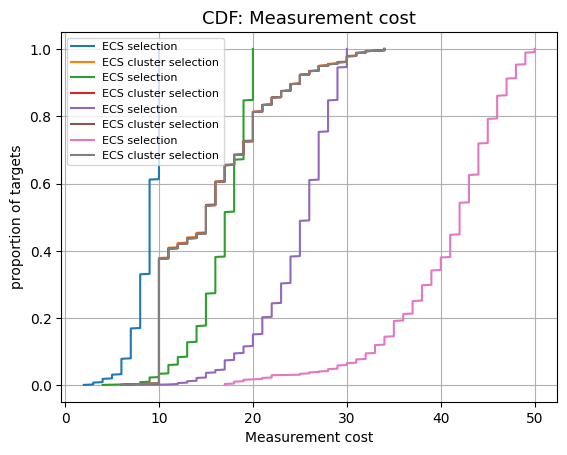

In [5]:
granularity = "answer_bgp_prefix"
results = eval_results[granularity]

fig, ax1 = plt.subplots(1, 1)

for budget, target_results in results.items():

    x, y = ecdf([len(r["ecs_vps_budget"]) for r in results[budget].values()])
    ax1.plot(x, y, label="ECS selection")

    avg_cost_ecs = round(
        np.mean([[len(r["ecs_vps_budget"]) for r in results[budget].values()]]),
        2,
    )
    median_cost_ecs = round(
        np.median([[len(r["ecs_vps_budget"]) for r in results[budget].values()]]),
        2,
    )

    x, y = ecdf([len(r["filtered_vps_per_cluster"]) for r in results[budget].values()])
    ax1.plot(x, y, label="ECS cluster selection")

    avg_cost_cluster = round(
        np.mean(
            [[len(r["filtered_vps_per_cluster"]) for r in results[budget].values()]]
        ),
        2,
    )
    median_cost_cluster = round(
        np.median(
            [[len(r["filtered_vps_per_cluster"]) for r in results[budget].values()]]
        ),
        2,
    )

    logger.info(f"Measurement cost = {budget}")
    logger.info(f"Avg Measurement cost ECS selection = {avg_cost_ecs}")
    logger.info(f"Median Measurement cost ECS selection = {median_cost_ecs}")
    logger.info(f"Avg Measurement cost cluster selection = {avg_cost_cluster}")
    logger.info(f"Median Measurement cost cluster selection = {median_cost_cluster}")

plt.xlabel("Measurement cost")
plt.ylabel("proportion of targets")
plt.legend(loc="upper left", fontsize=8)
plt.grid()
plt.title(
    f"CDF: Measurement cost",
    fontsize=13,
)
plt.savefig(path_settings.FIGURE_PATH / "measurement_cost_cluster_selection.pdf")
plt.show()

In [6]:
eval_results = load_pickle(
    path_settings.RESULTS_PATH
    / "evaluation_1M_hostnames_answer_bgp_prefix_max_bgp_prefix.pickle"
)

In [7]:
granularity = "answer_bgp_prefix"
results = eval_results[granularity]

hostname_filter = load_csv(path_settings.DATASET / "valid_hostnames_cdn.csv")
hostname_filter = [row.split(",")[0] for row in hostname_filter]
hostname_filter = "".join([f",'{h}'" for h in hostname_filter])[1:]
hostname_filter = f"AND hostname IN ({hostname_filter})"

count = 0
costs = []
for target_addr, target_results in eval_results[granularity][50].items():

    target = target_results["target"]
    ref_shortest_ping_vp = target_results["ref_shortest_ping_vp"]
    ecs_shortest_ping_vp = target_results["ecs_shortest_ping_vp"]
    no_ping_vp = target_results["no_ping_vp"]
    no_ping_cluster_vp = target_results["no_ping_cluster_vp"]

    diff_error = ref_shortest_ping_vp["d_error"] - no_ping_vp["d_error"]
    max_score = no_ping_vp["score"]

    if target_results["no_ping_vp"]["d_error"] > 5_00 and max_score > 0.6:

        logger.info("######################################")
        logger.info(f"Target : {target['addr']}")
        logger.info(f"Target BGP prefix : {target['bgp_prefix']}")
        logger.info("######################################")
        logger.info("Reference shortest ping VP:")
        logger.info(f"addr    = {ref_shortest_ping_vp['addr']}")
        logger.info(f"subnet  = {ref_shortest_ping_vp['subnet']}")
        logger.info(f"score   = {ref_shortest_ping_vp['score']}")
        logger.info(f"index   = {ref_shortest_ping_vp['index']}")
        logger.info(f"d error = {ref_shortest_ping_vp['d_error']}")
        logger.info(f"min rtt = {ref_shortest_ping_vp['rtt']}")
        logger.info(
            f"coordinates = {ref_shortest_ping_vp['lat']},{ref_shortest_ping_vp['lon']}"
        )
        logger.info(f"Diff error: {diff_error}")
        logger.info("######################################")
        logger.info("ECS-DNS elected VP:")
        logger.info(f"addr    = {ecs_shortest_ping_vp['addr']}")
        logger.info(f"subnet  = {ecs_shortest_ping_vp['subnet']}")
        logger.info(f"score   = {ecs_shortest_ping_vp['score']}")
        logger.info(f"index   = {ecs_shortest_ping_vp['index']}")
        logger.info(f"d error = {ecs_shortest_ping_vp['d_error']}")
        logger.info(f"min rtt = {ecs_shortest_ping_vp['rtt']}")
        logger.info(
            f"coordinates = {ecs_shortest_ping_vp['lat']},{ecs_shortest_ping_vp['lon']}"
        )
        logger.info("######################################")
        logger.info("No Ping VP:")
        logger.info(f"addr    = {no_ping_vp['addr']}")
        logger.info(f"subnet  = {no_ping_vp['subnet']}")
        logger.info(f"score   = {no_ping_vp['score']}")
        logger.info(f"index   = {no_ping_vp['index']}")
        logger.info(f"d error = {no_ping_vp['d_error']}")
        logger.info(f"min rtt = {no_ping_vp['rtt']}")
        logger.info(f"coordinates = {no_ping_vp['lat']},{no_ping_vp['lon']}")
        logger.info("######################################")
        logger.info("Cluster elected VP:")
        logger.info(f"addr    = {no_ping_cluster_vp['addr']}")
        logger.info(f"subnet  = {no_ping_cluster_vp['subnet']}")
        logger.info(f"score   = {no_ping_cluster_vp['score']}")
        logger.info(f"index   = {no_ping_cluster_vp['index']}")
        logger.info(f"d error = {no_ping_cluster_vp['d_error']}")
        logger.info(f"min rtt = {no_ping_cluster_vp['rtt']}")
        logger.info(
            f"coordinates = {no_ping_cluster_vp['lat']},{no_ping_cluster_vp['lon']}"
        )

        logger.info(f"nb vp selected: {len(target_results['ecs_vps'])}")
        logger.info(f"first vp scores: {target_results['ecs_vps']=}")

        logger.info(
            f"SELECT client_subnet, hostname, answer_subnet, answer_bgp_prefix, pop_ip_info_id, pop_city, pop_country, pop_continent from {clickhouse_settings.DATABASE}.{'old_dns_mapping_with_metadata'} where (client_subnet == toIPv4('{target['subnet']}') OR client_subnet == toIPv4('{ref_shortest_ping_vp['subnet']}') OR client_subnet == toIPv4('{ecs_shortest_ping_vp['subnet']}')) {hostname_filter} order by (hostname, client_subnet)"
        )
        logger.info("######################################")

        count += 1

        # if count > 20:
        #     break

        r_earth = 6378
        d = ecs_shortest_ping_vp["d_error"]
        target_lat, target_lon = target["lat"], target["lon"]
        new_latitude = target_lat + (d / r_earth) * (180 / pi)
        new_longitude = target_lon + (d / r_earth) * (180 / pi) / cos(
            target_lat * pi / 180
        )

        min_lat = target_lat - (d / r_earth) * (180 / pi)
        max_lat = target_lat + (d / r_earth) * (180 / pi)
        min_lon = target_lon - (d / r_earth) * (180 / pi) / cos(target_lat * pi / 180)
        max_lon = target_lon + (d / r_earth) * (180 / pi) / cos(target_lat * pi / 180)

        map = folium.Map(
            location=(target_lat, target_lon),
            zoom_start=6,
            min_lat=min_lat,
            max_lat=max_lat,
            min_lon=min_lon,
            max_lon=max_lon,
        )

        ping_done = 0
        for i, (label, vps) in enumerate(target_results["ecs_vps_per_cluster"].items()):
            for _, vp_lat, vp_lon, _ in vps:
                if label != -1:
                    plotDot(
                        vp_lat,
                        vp_lon,
                        map,
                        color="yellow",
                    )
                else:
                    plotDot(
                        vp_lat,
                        vp_lon,
                        map,
                        color="purple",
                    )

        logger.info(f"True number of VP selected: {ping_done}")

        # for label, vps in ecs_vps_per_cluster.items():
        #     if label == -1:
        #         continue

        #     for vp_addr, vp_lat, vp_lon, score in vps:
        #         max_score_vp_cluster = max(
        #             vp_in_cluster, key=lambda x: x[-1]
        #         )

        #         except KeyError:
        #             continue

        points = [
            (vp[1], vp[2]) for vp in target_results["ecs_vps_per_cluster"].values()
        ]
        if len(points) > 2:
            exterior_points, hull = find_exterior_points(points)
            folium.Polygon(
                locations=exterior_points,
                color="darkblue",
                weight=2,
                fill_color="blue",
                fill_opacity=0.2,
                fill=True,
            ).add_to(map)

            for point in exterior_points:
                plotDot(
                    point[0],
                    point[1],
                    map,
                    color="pink",
                )

        plotDot(
            target_lat,
            target_lon,
            map,
            color="red",
        )
        plotDot(
            ecs_shortest_ping_vp["lat"],
            ecs_shortest_ping_vp["lon"],
            map,
            color="lightblue",
        )
        plotDot(
            ref_shortest_ping_vp["lat"],
            ref_shortest_ping_vp["lon"],
            map,
            color="green",
        )
        plotDot(
            no_ping_vp["lat"],
            no_ping_vp["lon"],
            map,
            color="black",
        )
        plotDot(
            no_ping_cluster_vp["lat"],
            no_ping_cluster_vp["lon"],
            map,
            color="orange",
        )

        display(map)

logger.info(
    f"Number of IP address with wrongful geoloc: {count} ({round(count * 100 / len(targets), 1)} [%])"
)

2024-03-18 12:25:51.089 | INFO     | __main__:<module>:24 - ######################################
2024-03-18 12:25:51.091 | INFO     | __main__:<module>:25 - Target : 23.157.112.130
2024-03-18 12:25:51.093 | INFO     | __main__:<module>:26 - Target BGP prefix : (62538, '23.157.112.0/24')
2024-03-18 12:25:51.095 | INFO     | __main__:<module>:27 - ######################################
2024-03-18 12:25:51.097 | INFO     | __main__:<module>:28 - Reference shortest ping VP:
2024-03-18 12:25:51.099 | INFO     | __main__:<module>:29 - addr    = 23.132.96.169
2024-03-18 12:25:51.100 | INFO     | __main__:<module>:30 - subnet  = 23.132.96.0


2024-03-18 12:25:51.102 | INFO     | __main__:<module>:31 - score   = 0.7035024154589372
2024-03-18 12:25:51.104 | INFO     | __main__:<module>:32 - index   = 39
2024-03-18 12:25:51.105 | INFO     | __main__:<module>:33 - d error = 463.4471918113862
2024-03-18 12:25:51.106 | INFO     | __main__:<module>:34 - min rtt = 1.442455
2024-03-18 12:25:51.107 | INFO     | __main__:<module>:35 - coordinates = -121.9195,37.4705
2024-03-18 12:25:51.108 | INFO     | __main__:<module>:38 - Diff error: -2834.8053631202424
2024-03-18 12:25:51.109 | INFO     | __main__:<module>:39 - ######################################
2024-03-18 12:25:51.109 | INFO     | __main__:<module>:40 - ECS-DNS elected VP:
2024-03-18 12:25:51.111 | INFO     | __main__:<module>:41 - addr    = 23.132.96.169
2024-03-18 12:25:51.112 | INFO     | __main__:<module>:42 - subnet  = 23.132.96.0
2024-03-18 12:25:51.114 | INFO     | __main__:<module>:43 - score   = 0.7035024154589372
2024-03-18 12:25:51.115 | INFO     | __main__:<module

2024-03-18 12:25:51.181 | INFO     | __main__:<module>:24 - ######################################
2024-03-18 12:25:51.183 | INFO     | __main__:<module>:25 - Target : 23.168.145.10
2024-03-18 12:25:51.185 | INFO     | __main__:<module>:26 - Target BGP prefix : (398960, '23.168.145.0/24')
2024-03-18 12:25:51.186 | INFO     | __main__:<module>:27 - ######################################
2024-03-18 12:25:51.188 | INFO     | __main__:<module>:28 - Reference shortest ping VP:
2024-03-18 12:25:51.190 | INFO     | __main__:<module>:29 - addr    = 44.4.17.146
2024-03-18 12:25:51.191 | INFO     | __main__:<module>:30 - subnet  = 44.4.17.0
2024-03-18 12:25:51.192 | INFO     | __main__:<module>:31 - score   = 0.6282882882882883
2024-03-18 12:25:51.193 | INFO     | __main__:<module>:32 - index   = 16
2024-03-18 12:25:51.194 | INFO     | __main__:<module>:33 - d error = 0.2838406502229988
2024-03-18 12:25:51.196 | INFO     | __main__:<module>:34 - min rtt = 0.458443
2024-03-18 12:25:51.197 | INFO 

ValueError: could not convert string to float: '193.151.173.128'

In [ ]:
examples = [
    "79.142.69.12",
    "5.57.16.65",
    "23.157.112.130",
    "41.221.208.94",
    "45.142.246.158",
    "74.119.118.17",
]